# Plot Downloaded Products

This notebook show how to use the files downloaded in [](01a Download from Scihub.iypnb) and use them to preview their content and plot a true-color rendering of their contents. 
While the products already contain a True-Color Image (TCI), this approach is useful for two things:

1. It allows comparing the readings with a rendering provided by official sources, thereby allowing us to find errors
2. Generating a custom True-Color Image can be useful for further image manipulations, changing contrast or changing out single bands for others to highlight specific phenomena.

We start by reading the shape of Berlin previously downloaded from OpenStreetMap:

<AxesSubplot:>

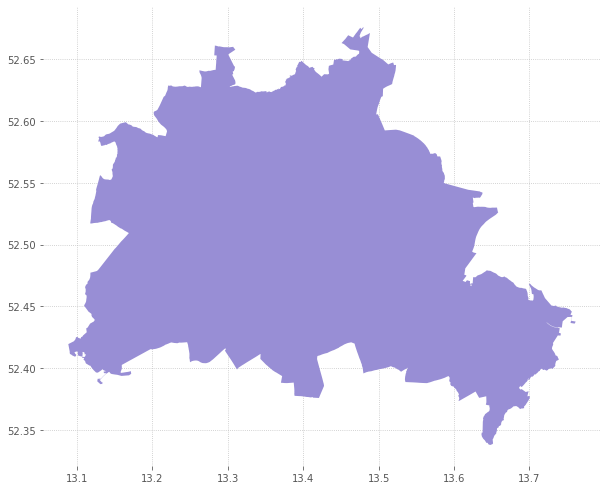

In [5]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

resources = Path('resources')
berlin = gpd.read_file(resources / 'berlin.geojson')

fig, ax = plt.subplots(figsize=(10, 10))
berlin.plot(ax=ax)

We know the product with the lowest cloud cover percentage from the previous notebook.

In [12]:
raster_files = resources / 'true_color_image'
product = next(raster_files.glob('S2B_MSIL2A_20200602T100559*.zip'))
product

PosixPath('resources/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip')

The product path contains a lot of information:

- `S2B` shows that the downloaded products was captured by the Sentinel-2 satellite B. At the moment there are two satellites in the mission, A and B.
- `MSI` stands for Multi Spectral Instrument.
- `L2A` is the processing level; Level 2A is the highest processing level and mostly. Lower processing levels need further processing depending on your use-case.
- The first timestamp, `20200602T100559`, is the date at which the data was captured.
- `N0214` is the processing baseline. This is like a version string that encodes how the previous processing steps were performed.
- `R022` is the relative orbit number.
- `T3UUU` is the UTM tile for which the product contains information.
- The second timestamp, `20200602T135324`, is "is the "\<Product Discriminator\>" field, which is 15 characters in length, and is used to distinguish between different end user products from the same datatake." ([Source](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention))

## Previewing Downloaded Files

There is a helper that, given a resolution and the band name, returns the correct file paths for us to use with the `rasterio` library.
It contains code to deal with compressed or uncompressed products.

In [13]:
from sentinel_helpers import scihub_band_paths
??scihub_band_paths

Signature: scihub_band_paths(p, bands, resolution=None)
Source:   
def scihub_band_paths(p, bands, resolution=None):
    '''
    Given a zip file or folder at `p`, returns the paths inside p to the raster files containing
    information for the given bands. Because some bands are available in more than one
    resolution, this can be filtered by prodiding a third parameter (e.g. resolution='10m').
    
    - `p` can be a string or a pathlib.Path.
    - `bands` can be a list of bands or a single band.
   
    The returned paths are formatted in the zip scheme as per Apache Commons VFS if necessary
    and can be directly opened by rasterio.
    '''
    if type(bands) != list:
        # allow passing in a single band more easily
        bands = [bands]
    
    p = Path(p) # make sure we're dealing with a pathlib.Path
    if p.suffix == '.zip':
        # when dealing with zip files we have to read the filenames from the
        # archive first
        with ZipFile(p) as f:
            f

Using the compressed zip-file, while slightly inconvenient, makes sense because it allows saving disk space and allows us to avoid the extra step of decompressing every single downloaded product.

There is a pre-rendered True-Color Image ("TCI") that we can use to get a quick plot of the contents:

In [14]:
low_res_tci = scihub_band_paths(product, 'TCI', '60m')[0]
low_res_tci

PosixPath('zip+file:/home/jovyan/sources/resources/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip!/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.SAFE/GRANULE/L2A_T33UUU_A016922_20200602T101204/IMG_DATA/R60m/T33UUU_20200602T100559_TCI_60m.jp2')

Using the `rasterio` library we can open this image and render its contents:

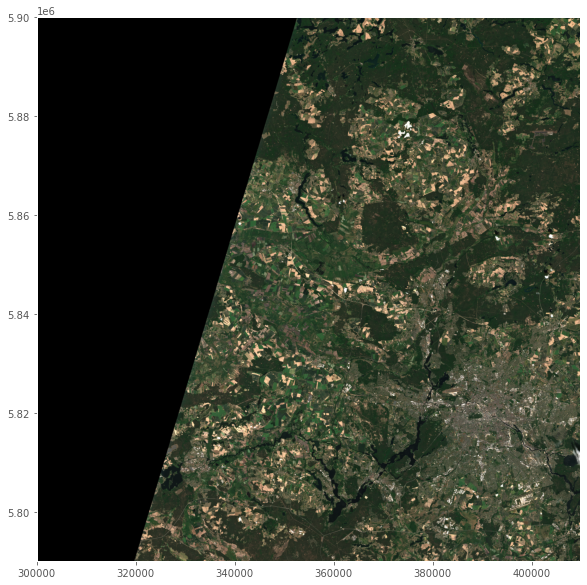

In [17]:
import matplotlib.pyplot as plt
import rasterio as r
import rasterio.plot as rplt

plt.style.use('ggplot')

with r.open(low_res_tci) as tci:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    rplt.show(tci)

## Creating Your Own Composed Image

While for many use cases using the TCI can be enough, knowing how to compose True-Color Images provides additional merit as explained above.

The blue, green, and red parts of the spectrum are represented in the raster files for the bands 2, 3 and 4 respectively
`sentinel_helpers.py` contains a helper that wraps `scihub_band_paths` to retrieve those bands in a resolution of our choice:

In [6]:
from sentinel_helpers import scihub_bgr_paths
??scihub_bgr_paths

Signature: scihub_bgr_paths(product_path, resolution=None)
Source:   
def scihub_bgr_paths(product_path, resolution=None):
    '''
    A convenence function to return the paths to the blue, green and red bands
    in the downloaded product at `product_path`.
    '''
    return scihub_band_paths(product_path, ['B02', 'B03', 'B04'], resolution)
File:      ~/sources/sentinel_helpers.py
Type:      function


In [7]:
b02, b03, b04 = scihub_bgr_paths(product, '60m')
b02.name, b03.name, b04.name

('T33UUU_20200602T100559_B02_60m.jp2',
 'T33UUU_20200602T100559_B03_60m.jp2',
 'T33UUU_20200602T100559_B04_60m.jp2')

We can plot a combination of these bands:

In [8]:
with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red:
    plt.figure(figsize=(10, 10))
    
    # calling blue.read(1) returns the first raster band of the blue raster
    # file as a numpy array. each raster file can contain multiple bands and
    # unfortunately the different parts of the spectrum are called "bands" as well.
    rplt.show([scihub_normalize_range(red.read(1)),
               scihub_normalize_range(green.read(1)),
               scihub_normalize_range(blue.read(1))],
              # we need to pass the transform explicitly if we want the plot
              # to be labelled correctly because the numpy array does not,
              # contain information about world coordinates it only uses
              # array indices
              transform=blue.transform)

NameError: name 'scihub_normalize_range' is not defined

<Figure size 720x720 with 0 Axes>

- We can't just plot images by combining the different bands
- The raster files contain values outside of the allowed range
- TCI is produced like this: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/definitions

> The TCI is an RGB image built from the B02 (Blue), B03 (Green), and B04 (Red) Bands. The reflectances are coded between 1 and 255, 0 being reserved for 'No Data'. The saturation level of 255 digital counts correspond to a level of 3558 for L1C products or 2000 for L2A products (0.3558 and 0.2 in reflectance value respectively.

- This is what happens when we plot naively
  - Left to right: pre-rendered `TCI`, middle: just plot it, right: clipped image

In [ ]:
with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27,9))
    transform = blue.transform
    
    rplt.show(tci, transform=transform, ax=ax1)
    rplt.show([red.read(1), green.read(1), blue.read(1)],
              transform=transform, ax=ax2)
    rplt.show([scihub_normalize_range(red.read(1)),
               scihub_normalize_range(green.read(1)),
               scihub_normalize_range(blue.read(1))],
              transform=transform, ax=ax3)
    
    plt.show()
    fig.savefig(resources / 'berlin_true_color_image_naive_plot.png', dpi=300)

- **TODO** Compare histogram

## Hi-Resolution Plot

### Subsetting to the desired area

In [ ]:
b02, b03, b04 = scihub_bgr_paths(product, '10m')
b02.name, b03.name, b04.name

In [ ]:
blue = r.open(b02)

- Make sure our area of interest and the raster files have the same coordinate reference system

- **TODO** Use mask instead?

In [ ]:
# see https://github.com/mapbox/rasterio/blob/d7b2dd3ae64c55978e265fa9230732e88b1dc9ae/rasterio/rio/clip.py

from rasterio.windows import Window

with r.open(b02) as src:
    bounds = berlin.to_crs(blue.crs).bounds.loc[0].values
    out_window = src.window(*bounds).round_lengths(op='floor')
    out_window = out_window.intersection(
        Window(0, 0, src.width, src.height)
    )
    
    height = int(out_window.height)
    width = int(out_window.width)

    out_kwargs = src.profile
    out_kwargs.update({
        'height': height,
        'width': width,
        'transform': src.window_transform(out_window)})

    with r.open('/tmp/window.jp2', "w", **out_kwargs) as out:
        out.write(
            src.read(
                window=out_window,
                out_shape=(src.count, height, width),
                boundless=True,
            )
        )

In [ ]:
with r.open('/tmp/window.jp2') as src:
    rplt.show(src)

We write convert the data type when combining the bands:

- `scihub_normalize_range` gives us floats in a valid range $\in [0..1]$ which is nice and convenient to work with
- When using 8 bit integers we are operating in RGB-space as used by `BMP`s and rasterio recognizes this when selecting a scale

In [ ]:
from tqdm.notebook import tqdm

with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red:
    # we re-use out-window, width and height from above
    out_kwargs = blue.profile
    out_kwargs.update({
        'count': 3, # number of bands
        'height': height,
        'width': width,
        'transform': blue.window_transform(out_window),
        'driver': 'GTiff',
        'dtype': np.uint8
    })

    # we're using a temporary file for demonstration purposes; if you want to
    # save the result somewhere else you'd probably use a `pathlib.Path`.
    with NamedTemporaryFile() as tmp:
        with r.open(tmp.name, 'w+', **out_kwargs) as out:
            src_bands = [red, green, blue]
            
            # write output tiff
            for idx, src in tqdm(enumerate(src_bands, start=1), desc=f'Writing bands to {tmp.name}'):
                subset = scihub_normalize_range(src.read(
                    1,
                    window=out_window,
                    out_shape=(1, height, width),
                    boundless=True,
                ))
                out.write((subset * 255).astype(np.uint8), idx)
                
            # plot the generated output
            fig, ax = plt.subplots(figsize=(20, 20))
            rplt.show(src, ax=ax)
            berlin.to_crs(src.crs).plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)